#  Домашнее задание 2. Составление словарей для классификации по тональности

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на
следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”). Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье [Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora](https://arxiv.org/pdf/1606.02820v1.pdf).

Данные для задания ( dropbox ) – отзывы на банки, собранные с
нескольких сайтов Рунета. Отзывы могут быть как положительными,
так и отрицательными.

### Задание 1
Предобработка и первичный анализ текстов: разбейте тексты на слова, посчитайте описательные статистики (среднюю длину отзыва, количество разных частей речи и еще что-нибудь, что представляется вам разумным). Приведите слова к нормальной форме, используя любой симпатичный вам морфологический процессор.

Постройте частотные словари, посмотрите на самые частые слова в отзывах, самые частые слова в положительных отзывах и самые частые слова в отрицательных отзывах.

In [1]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk
from nltk import FreqDist
import json
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

Посчитаем общее собранное количество отзывов на банки

In [9]:
num_lines = sum(1 for line in open('banki_responses.json'))
print (num_lines)

201030


In [10]:
#with open('banki_responses.json') as foo:
#    num_lines = len(foo.readlines())
#print (num_lines)  
# MemoryError: 

Оценим из как сформирован json файл для его дальнейшей обработки

In [11]:
# https://stackoverflow.com/questions/21533894/how-to-read-line-delimited-json-from-large-file-line-by-line/21533989
import json
contents = open('banki_responses.json', "r").readline() 
data = [json.loads(str(item)) for item in contents.strip().split('\n')][0] # [0] чтобы из листа вынуть словарь

In [12]:
data

{'author': 'e.novikova',
 'bank_license': 'лицензия № 1623',
 'bank_name': 'ВТБ 24',
 'city': 'г. Воронеж',
 'datetime': '2015-06-08 11:06:56',
 'num_comments': 0,
 'rating_grade': 5,
 'rating_not_checked': True,
 'text': 'Здравствуйте!  Хотелось бы выразить благодарность банку ВТБ24 г.Воронеж пл. Ленина и непосредственно специалисту по ипотечному кредитованию Мещеряковой Юлии Анатольевне. Это уже моя вторая ипотека в этом банке и у этого специалиста. Вопросов с подачей документов не было, быстрое принятие решения об одобрении всей необходимой суммы и никаких проблем с выдачей кредита. Удобно, что никуда не нужно ходить и со сторонними организациями не нужно договариваться. На оценку сотрудники банка приехали вовремя, страховку оформили перед выдачей кредита в отделении банка. Все быстро, четко, слаженно. На все мои вопросы о сравнении условий Юлия подробно отвечала, что сомнений никаких не возникло в каком именно банке брать (был выбор между сбербанком и втб24). Из дополнительных расх

Сформируем таблицу формата pandas DataFrame, проанализируем первые 10 отзывов

In [13]:
# http://cmdlinetips.com/2011/08/three-ways-to-read-a-text-file-line-by-line-in-python/
df = pd.DataFrame()
df = pd.DataFrame(columns=['bank_name','rating_grade','text','title'])

file = open('banki_responses.json', 'r')
i=0
for contents in iter(file):
    if i==10 : break #  ограничиваем количество скачиваемых строк  json
    values = [json.loads(str(item)) for item in contents.strip().split('\n')][0]
    
    valueDict = {}
    valueDict['bank_name'] = values['bank_name']
    valueDict['rating_grade'] = values['rating_grade']
    valueDict['rating_not_checked'] = values['rating_not_checked']
    valueDict['text'] = values['text']
    valueDict['title'] = values['title']
    df = df.append(valueDict, ignore_index=True)    
    i+=1
    
file.close()

In [14]:
df

,bank_name,rating_grade,text,title,rating_not_checked
0,ВТБ 24,5.0,Здравствуйте! Хотелось бы выразить благодарно...,Ипотека на 5+,1.0
1,Русский Стандарт,2.0,Уважаемые представители департамента по работе...,ЗВОНКИ СОСЕДЯМ,1.0
2,Союз,2.0,Здравствуйте. Столкнулась с такой ситуацией. в...,Ложная информация!!!!,1.0
3,Ситибанк,1.0,1 июня 2015 в Москве в отделении по адресу Смо...,Банкомат не зачислил деньги на счет,1.0
4,Ренессанс Кредит,1.0,История очень долгая! Пришел я в банк (это раз...,Невозможно закрыть карту 2(два)!!!,1.0
5,Бинбанк,NaN,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,0.0
6,Сбербанк России,NaN,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,0.0
7,Кубань Кредит,3.0,Здравствуйте. Есть у меня VISA Electron от Куб...,Информирование по электронной почте.,1.0
8,ВТБ 24,2.0,"Послеотзыва лицензии у Транспортного, с нетерп...",Выплаты по Транспортному,1.0
9,ВТБ 24,5.0,Хочу поблагодарить Надежду из отдела по ипотеч...,Большая блаодарность!,1.0


In [15]:
import os
file_size = os.stat('banki_responses.json').st_size
print (file_size)

1561923934


Оценим скорость работы при считывании файла данных размером 1.6Г по строчно

In [16]:
%%time

bank_name,rating_grade =[],[]
len_text,len_text_P,len_text_N = [],[],[] # P - позитивный отзыв, N - негативный отзыв

file = open('banki_responses.json', 'r')
i=0
for contents in tqdm(iter(file)):
    #if i==100 : break #  ограничиваем количество скачиваемых строк  json
    values = [json.loads(str(item)) for item in contents.strip().split('\n')][0]
    bank_name.append(values['bank_name'])
    rating_grade.append(values['rating_grade']) 
    
    text_raw=values['text']
    len_text.append(len(text_raw)) 
    if     values['rating_grade'] is not None :
        if values['rating_grade'] >=4 :
            len_text_P.append(len(text_raw)) 
        else:
            len_text_N.append(len(text_raw)) 
           
    i+=1
    
file.close()
print(i)

201030it [00:42, 4775.12it/s]


201030
Wall time: 42.1 s


Рассчитаем статистику по длине (по количеству символов) позитивных и негативных отзывов

In [17]:
pd.DataFrame([pd.Series(len_text).describe(),pd.Series(len_text_P).describe(),pd.Series(len_text_N).describe()],
            index=['все отзывы','позитивные','негативные'])

,count,mean,std,min,25%,50%,75%,max
все отзывы,201030.0,1455.372178,1250.735661,22.0,680.0,1110.0,1803.0,32082.0
позитивные,32252.0,1203.347389,1050.022484,22.0,565.0,913.0,1482.0,28577.0
негативные,103937.0,1612.184092,1325.641125,29.0,782.0,1252.0,2002.0,32082.0


Оценим скорость работы при считывании файла данных размером 1.6Г порциями - chunksize

In [18]:
file_size/(1024*10000)

152.5316341796875

In [21]:
%%time
# https://www.reddit.com/r/learnpython/comments/52vpjz/chunking_in_pythonhow_to_set_the_chunk_size_of/
chunksize = 1024*10000
bank_name,rating_grade =[],[]
len_text,len_text_P,len_text_N = [],[],[] # P - позитивный отзыв, N - негативный отзыв

i=0
with open('banki_responses.json', 'r') as file:
    while True:
        read_data = file.readlines(chunksize)
        for contents in read_data :
                values = [json.loads(str(item)) for item in contents.strip().split('\n')][0]                
                bank_name.append(values['bank_name'])
                rating_grade.append(values['rating_grade']) 
                
                text_raw=values['text']
                len_text.append(len(text_raw)) 
                if     values['rating_grade'] is not None :
                    if values['rating_grade'] >=4 :
                        len_text_P.append(len(text_raw)) 
                    else:
                        len_text_N.append(len(text_raw))       
                
        if not read_data: break # done    
        i+=1
file.close()
print(i)

153
Wall time: 43.4 s


Для целей анализа за позитивный отзыв считались отзывы с rating_grade>=4, за негативный  <4  

Оценим рапределение оценок отзывов= тональностей отзывов. Заметен сильный перекос в сторону негативных комментариев. Это етественно поскольку чаще пишут негативные замечания. Такая неравномерность может помишать выбору слов для словаря тональностей, поскольку текст получается слишком окрашенных в сторону негативных отзывов. 

Исправить ситуацию можно было сэмплировав исходный корпус  уменьшая дисбаланс, или же добавляя дополнительный нейтральный корпус (русская выкипедия) для увеличения контрастности исходного корпуса.

In [22]:
pd.Series(rating_grade).value_counts()

1.0    72307
5.0    26715
2.0    19928
3.0    11702
4.0     5537
dtype: int64

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

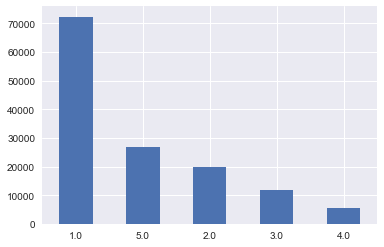

In [24]:
pd.Series(rating_grade).value_counts().plot(kind="bar", rot=0);

Сильная концентрация отзывов у отдельной групппы банков может приводить к ситуации когда само название банка будет становиться оценочным словом словаря тональности, что не верно. Для того чтобы избежать таких ошибок  при предобработке текстов необходимо заменить все названия банков на -  #Банк.

In [25]:
pd.Series(bank_name).value_counts()[:10]

Сбербанк России              30977
Альфа-Банк                   13651
Русский Стандарт             10952
ВТБ 24                       10556
Хоум Кредит Банк             10130
Тинькофф Банк                 7774
Национальный Банк «Траст»     6092
Связной Банк                  5349
Ренессанс Кредит              5314
ОТП Банк                      4276
dtype: int64

Воспользуемся фунцией для частей речи текста из прошлого задания

In [9]:
from nltk import FreqDist

def get_POS_tag(gram_info):   
    POS_tag=[]
    for i in range(len(gram_info)):    
        if not gram_info[i]["text"].isspace():
            # если по какой то причине прошли символы которые не отфильтровались выше то для для не будет 
            # определена часть речи и будет пустой list
            if len(gram_info[i]["analysis"])==1:       
                POS_tag.append(gram_info[i]["analysis"][0]["gr"].split(',')[0].split('=')[0])

    fd_POS_tag = FreqDist()
    fd_POS_tag.update(POS_tag)            
    return fd_POS_tag     

In [57]:
%%time
import re
regex = re.compile("[А-Яа-я]+") 

from pymystem3 import Mystem
m = Mystem()
from pymorphy2 import MorphAnalyzer
ma = MorphAnalyzer()

from nltk import FreqDist
POS_tag_fd = FreqDist() 
POS_tag_P = FreqDist()
POS_tag_N = FreqDist()

most_freq_fd = FreqDist() 
most_freq_P = FreqDist()
most_freq_N = FreqDist()

i=0
file = open('banki_responses.json', 'r')
    
for contents in tqdm(iter(file)):
    if i==100  : break #  ограничиваем количество скачиваемых строк  json
    values = [json.loads(str(item)) for item in contents.strip().split('\n')][0]
    text_raw = values['text']
    text_re =regex.findall(text_raw.lower())
        
    # лемматизируем все тексты с помощью MorphAnalyzer    
    token=[ma.parse(word)[0].normal_form for word in text_re]        
    text_lemtz = " ".join(token)
    most_freq_fd.update(token) 
        
    # получим информацию о частях речи загруженного отзыва
    gram_info = m.analyze(text_lemtz)                
    POS_tag_= get_POS_tag(gram_info)
    POS_tag_fd.update(POS_tag_)     
    
    # получим информацию о частях речи загруженного отзыва в зав-ти от rating_grade
    if     values['rating_grade'] is not None :
        if values['rating_grade'] >=4 :
            POS_tag_P.update(POS_tag_)
            most_freq_P.update(token)
        else:
            POS_tag_N.update(POS_tag_)
            most_freq_N.update(token)
                
 
    i+=1
file.close()

100it [02:35,  1.49s/it]

Wall time: 2min 36s


По всей видимости существует проблема с потоками  управления для 32 битной Windows. Mystem необходимо вынести за периметр цикла. Для этого сформируем предобработанные файлы позитивныx и негативных отзывов и применим Mystem целиком к файлу.
Чтобы не проходить циклом по всему json дважды, сразу сформируем файл формата word2vec.

Сделаем предобработку текста - удалим стоп-слова, и лемматизируем слова

In [4]:
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')
print(stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

Сформируем свой список стоп слов. Часть слов которые могут иметь отношение к тональности - senti_word, удалим из словаря nltk stopwords, также добавим некоторые собственные стоп слова которые явно будут лишними для данной тематики отзывов

In [5]:
senti_word=['теперь','даже','если', 'уже','опять','будто','никогда','наконец',\
            'лучше','хорошо','более','наконец','два','также','нельзя']
my_stopwords=['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'банк']

In [6]:
final_stopwords=(set(stopwords).difference(set(senti_word))).union(set(my_stopwords))

In [7]:
%%time
from tqdm import tqdm
import re
regex = re.compile("[А-Яа-я]+") 

from pymorphy2 import MorphAnalyzer
ma = MorphAnalyzer()

from nltk import FreqDist
most_freq_fd = FreqDist() 
most_freq_P = FreqDist()
most_freq_N = FreqDist()

i=0
file = open('banki_responses.json', 'r')
with open ('w2v_format.txt', 'w') as f:
    with open ('Positive.txt', 'w') as fP:
        with open ('Negative.txt', 'w') as fN:    
    
            for contents in tqdm(iter(file),miniters=2000,leave=False):
                #if i==10  : break #  ограничиваем количество скачиваемых строк  json
                values = [json.loads(str(item)) for item in contents.strip().split('\n')][0]
                text_raw = values['text']
                rating = values['rating_grade'] 

                text_re =regex.findall(text_raw.lower())
                #  удалим стоп-слова
                text_del_sw = [token for token in text_re if not token in final_stopwords]        
                # лемматизируем все тексты с помощью MorphAnalyzer    
                token=[ma.parse(word)[0].normal_form for word in text_del_sw]        
                text_lemtz = " ".join(token)
                text_w2v= ",".join(token)
                
                most_freq_fd.update(token) 
                f.write(text_w2v + '\n')

                # получим информацию о наиболее чпстых словах в зав-ти от rating_grade
                if     rating is not None :
                    if rating >=4 :                
                        most_freq_P.update(token)
                        fP.write(text_lemtz + '\n')
                    else:
                        most_freq_N.update(token)
                        fN.write(text_lemtz + '\n')

                i+=1
file.close()

Wall time: 2h 15min 18s


Посмотрим наиболее частые слова во всех отзывах, в положительных, и отрицательных отзывах. Категория 'все отзывы' включает также не размеченные через rating_grade отзывы

In [50]:
from collections import OrderedDict
most_freq_fd = OrderedDict(sorted(most_freq_fd.items(), key=lambda x: x[1],reverse=True))
most_freq_P  = OrderedDict(sorted(most_freq_P.items(), key=lambda x: x[1],reverse=True))
most_freq_N  = OrderedDict(sorted(most_freq_N.items(), key=lambda x: x[1],reverse=True))

In [55]:
all_most_freq=pd.concat([pd.DataFrame.from_dict(data=most_freq_fd,orient='index').reset_index(), 
                        pd.DataFrame.from_dict(data=most_freq_P,orient='index').reset_index(),
                        pd.DataFrame.from_dict(data=most_freq_N,orient='index').reset_index()], axis=1)
all_most_freq.columns=['все отзывы','count','позитивные','count','негативные','count']
all_most_freq[:20]

,все отзывы,count,позитивные,count,негативные,count
0,банка,505193,банка,75643.0,банка,279231.0
1,карта,404447,карта,45928.0,карта,234958.0
2,деньга,218647,очень,30570.0,деньга,131779.0
3,год,209218,кредит,27177.0,день,122264.0
4,кредит,207381,клиент,26318.0,год,116181.0
5,день,204832,год,26211.0,кредит,115351.0
6,мой,187952,отделение,23853.0,мой,107122.0
7,который,183114,сотрудник,23660.0,отделение,106480.0
8,клиент,172909,день,23389.0,который,106107.0
9,отделение,168773,вклад,22806.0,клиент,97716.0


Рассмотрим распределение частей речи по разным отзывам

In [6]:
%%time
from tqdm import tqdm
POS_tag_=[]
POS_tag_P = FreqDist()
i=0
with open('Positive.txt', 'r') as f:
    for line in tqdm(f):
        #if i==5 : break
        text= line.split()
        for text_ in text:
            p = ma.parse(text_)[0]
            POS_tag_.append(p.tag.POS)   
        i+=1
        
POS_tag_P.update(POS_tag_)           

32252it [18:02, 29.78it/s]


Wall time: 18min 18s


In [39]:
%%time 
POS_tag_=[]
POS_tag_N = FreqDist()
i=0
with open('Negative.txt', 'r') as f:
    for line in tqdm(f):   
        #if i==5 : break
        text= line.split()
        for text_ in text:
            p = ma.parse(text_)[0]
            POS_tag_.append(p.tag.POS)   
        i+=1
        
POS_tag_N.update(POS_tag_)    

Wall time: 1h 9min 58s


Распределение в процентах частей речи в позитивных и негативных отзывах

In [65]:
index, values = zip(*list(POS_tag_N.items()))
text_tag_N = pd.DataFrame(np.array(values)*100/sum(values),list(index),columns=['негативный отзыв'])
index, values = zip(*list(POS_tag_P.items()))
text_tag_P = pd.DataFrame(np.array(values)*100/sum(values),list(index),columns=['позитивный отзыв'])

all_text_tag=pd.concat([text_tag_N, text_tag_P], axis=1)
all_text_tag

,негативный отзыв,позитивный отзыв
ADJF,14.454042,16.295418
ADVB,6.446214,8.250330
CONJ,1.538879,1.520430
INFN,25.308424,22.714375
NOUN,47.645573,46.616348
NPRO,0.664572,0.493448
NUMR,0.522493,0.456345
PRCL,1.012224,1.055767
VERB,0.173865,0.126002
NaN,1.249557,1.201990


### Задание 2
По полученному файлу формата word2vec обучим модель по всей коллекции отзывов. Построим лексический граф.

In [2]:
text_w2v=[]
with open('w2v_format.txt', 'r') as f:
    for line in f:
        text_w2v.append(line.strip().split(','))

In [3]:
len(text_w2v)

201030

In [4]:
text_w2v[1][:5]

['уважаемый', 'представитель', 'департамент', 'работа', 'просрочить']

In [85]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [86]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(text_w2v, size=100, window=5, min_count=5, workers=4)
model.save("bank_w2v.model")

2017-05-24 19:37:45,811 : WARNING : Slow version of gensim.models.word2vec is being used
2017-05-24 19:37:45,827 : INFO : collecting all words and their counts
2017-05-24 19:37:45,827 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-24 19:37:46,124 : INFO : PROGRESS: at sentence #10000, processed 1217517 words, keeping 26164 word types
2017-05-24 19:37:46,639 : INFO : PROGRESS: at sentence #20000, processed 2440759 words, keeping 34702 word types
2017-05-24 19:37:47,139 : INFO : PROGRESS: at sentence #30000, processed 3641456 words, keeping 41293 word types
2017-05-24 19:37:47,874 : INFO : PROGRESS: at sentence #40000, processed 4905099 words, keeping 46618 word types
2017-05-24 19:37:50,499 : INFO : PROGRESS: at sentence #50000, processed 6213994 words, keeping 51334 word types
2017-05-24 19:37:53,437 : INFO : PROGRESS: at sentence #60000, processed 7492268 words, keeping 55413 word types
2017-05-24 19:37:57,219 : INFO : PROGRESS: at sentence #70000, 

MemoryError: 

In [114]:
dict_w2v=list(model.wv.vocab.keys())
print (len(dict_w2v))

36182


In [ ]:
# https://github.com/RaRe-Technologies/gensim/issues/1069

In [93]:
model.wv.save_word2vec_format("bank_w2v")

2017-05-25 11:03:15,330 : INFO : storing 36182x100 projection weights into bank_w2v


In [110]:
# https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import KeyedVectors
model2 = KeyedVectors.load_word2vec_format("bank_w2v",limit=10)

2017-05-25 11:55:20,672 : INFO : loading projection weights from bank_w2v
2017-05-25 11:55:20,719 : INFO : loaded (10, 100) matrix from bank_w2v


In [113]:
model2.vocab.keys()

dict_keys(['банка', 'карта', 'деньга', 'год', 'кредит', 'день', 'мой', 'который', 'клиент', 'отделение'])

In [129]:
import sys
sys.getsizeof(model)

32

In [163]:
from pympler import asizeof
asizeof.asizeof(model,limit=5)

33442840

In [168]:
# https://stackoverflow.com/questions/17513036/pickle-dump-huge-file-without-memory-error

In [126]:
import _pickle as cPickle
file = open("bank_w2v_pkl", 'w')
cPickle.dump(model, file,protocol=3)
file.close()

MemoryError: 

In [167]:
import hickle as hkl
hkl.dump(model, 'bank_w2v.hkl', mode='w')

ImportError: DLL load failed: Недостаточно памяти для обработки команды.

Из-за проблем с памятью текущая задача была решена для половины всей коллекции отзывов

In [5]:
text_w2v=[]
i=0
with open('w2v_format.txt', 'r') as f:
    for line in f:
        if i==100000  : break
        text_w2v.append(line.strip().split(','))
        i+=1

In [6]:
len(text_w2v)

100000

In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(text_w2v, size=100, window=5, min_count=5, workers=4)
model.save("bank_w2v.model")

2017-05-26 22:43:35,689 : WARNING : Slow version of gensim.models.doc2vec is being used
2017-05-26 22:43:35,921 : INFO : 'pattern' package not found; tag filters are not available for English
2017-05-26 22:43:35,985 : WARNING : Slow version of gensim.models.word2vec is being used
2017-05-26 22:43:36,084 : INFO : collecting all words and their counts
2017-05-26 22:43:36,090 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-26 22:43:36,451 : INFO : PROGRESS: at sentence #10000, processed 1217517 words, keeping 26164 word types
2017-05-26 22:43:36,801 : INFO : PROGRESS: at sentence #20000, processed 2440759 words, keeping 34702 word types
2017-05-26 22:43:37,147 : INFO : PROGRESS: at sentence #30000, processed 3641456 words, keeping 41293 word types
2017-05-26 22:43:37,522 : INFO : PROGRESS: at sentence #40000, processed 4905099 words, keeping 46618 word types
2017-05-26 22:43:37,906 : INFO : PROGRESS: at sentence #50000, processed 6213994 words, keeping 5

Wall time: 6h 2min 10s


In [2]:
from gensim.models import Word2Vec
model = Word2Vec.load("bank_w2v.model") 

Slow version of gensim.models.doc2vec is being used


In [9]:
dict_w2v=list(model.wv.vocab.keys())
top5_words,_=zip(*model.similar_by_word('быдло',topn=5))
top5_words

2017-05-27 10:31:47,466 : INFO : precomputing L2-norms of word weight vectors


('базар', 'хам', 'хамть', 'базарный', 'напор')

In [12]:
len(dict_w2v)

25556

Реализуем лексичекий граф в котором вершины (vertex, node) - слова из словаря полученной модели word2vec, ребра (edge)- топ-5 слов по косинусной близости к слову вершине графа. Для визуализации графа будем использовать программу  Gephi. Создадим файлы вершин-меток и ребер необходимого формата для работы с программой

In [10]:
# https://gephi.org/users/supported-graph-formats/spreadsheet/
# https://www.youtube.com/watch?v=FpOIbhOmGUs
from tqdm import tqdm
i=1
node_list=[]
with open ('edge.txt', 'w') as fe:            
        for dict_w2v_ in tqdm(dict_w2v):
                if i==1:                   
                    fe.write('Source,Target' +'\n')                    
                node_list.append(dict_w2v_)
                edge,_=zip(*model.similar_by_word('год',topn=5))
                for edge_ in edge:
                    fe.write(dict_w2v_ + ','+ edge_+ '\n')
                    node_list.append(edge_)                
                node_list=list(set(node_list))
                i+=1

100%|███████████████████████████████████| 25556/25556 [01:31<00:00, 280.09it/s]


In [11]:
i=1
with open ('node.txt', 'w') as fn: 
    for node_list_ in tqdm(node_list):
        if i==1:
            fn.write('Id,Label' + '\n')
        fn.write(node_list_ + ','+ node_list_+ '\n')
        i+=1

100%|████████████████████████████████| 25556/25556 [00:00<00:00, 136290.69it/s]


<center>
### Визуализация лексического графа
<img src="https://img-fotki.yandex.ru/get/95629/338176967.1/0_164937_c2928553_XXL">

### Задание 3
Реализуем алгоритм Label propagation из пакета sckit-learn. В sckit-learn непомеченным меткам присваиется значение -1 (минус один), на эти метки будет происходить обучение алгоритма. Для негативных меток используется значение - 0, для позитивных - 1. Итогом работы будет полностью размеченные значения тональности оценочных слов из словаря.

In [13]:
model.similar_by_word('кредитор')

[('заёмщик', 0.7623782157897949),
 ('мщик', 0.711681067943573),
 ('заём', 0.6794826984405518),
 ('залогодержатель', 0.6634179353713989),
 ('выгодоприобретатель', 0.6377538442611694),
 ('залогодатель', 0.6279994249343872),
 ('переуступка', 0.6122592687606812),
 ('займодавец', 0.607208251953125),
 ('допускаться', 0.5976113677024841),
 ('созаёмщик', 0.5973631739616394)]

In [14]:
model.similar_by_word('удобно')

[('неудобно', 0.7797819375991821),
 ('удобный', 0.7792823314666748),
 ('здорово', 0.6698466539382935),
 ('нравиться', 0.6676340103149414),
 ('редко', 0.6362782716751099),
 ('безопасно', 0.6162109971046448),
 ('проблематично', 0.6088219285011292),
 ('комфортно', 0.6032885313034058),
 ('понравиться', 0.593193769454956),
 ('круто', 0.5843707323074341)]

In [15]:
model.similar_by_word('плохо')

[('грустно', 0.7439620494842529),
 ('тяжело', 0.7224091291427612),
 ('печально', 0.6952850818634033),
 ('глупо', 0.6831182241439819),
 ('медленно', 0.6641258597373962),
 ('весело', 0.6611217260360718),
 ('опасный', 0.6596537828445435),
 ('злой', 0.6428864598274231),
 ('топорно', 0.6324974298477173),
 ('здорово', 0.6296331286430359)]

Итогом работы алгоритма word2vec является векторное представление слова, в текущем случае 100 мерный вектор. Визуализируем вектора двух семантически похожих слов

In [17]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


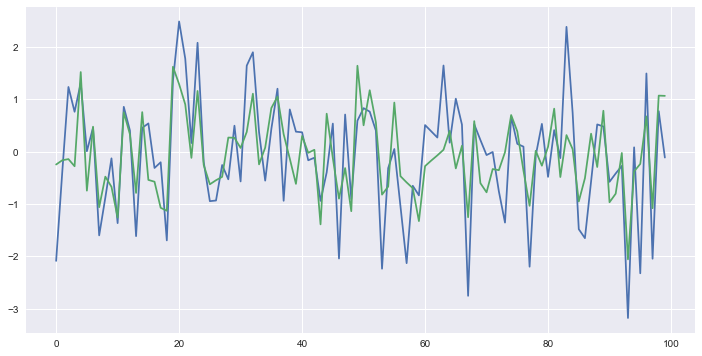

In [20]:
plt.figure(figsize(12,6))
plot(model['плохо'])
plot(model['печально']);

Выберем слова которые будут основой словаря оценочных слов. С этих помеченных слов бует "стартовать" алгоритм Label propagation

In [4]:
marker_words= ['удобно', 'здорово', 'нравиться', 'плохо', 'грустно', 'печально']

In [5]:
unlabeled_words = list(filter(lambda v: v not in marker_words, dict_w2v))
len(unlabeled_words)

25550

Чтобы не было ошибки по памяти сократим размер словаря

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [17]:
# непомеченным словам присваиваем -1
X_unlabeled=model[unlabeled_words][:5000]
#y_unlabeled=[-1]*len(X_unlabeled)
y_unlabeled=[-1]*5000

# поченным в зависимости от тональности 0 или 1
X_labeled=model[marker_words]
y_labeled=[1,1,1,0,0,0]

X = np.vstack((X_labeled,X_unlabeled))
y = np.hstack((y_labeled,y_unlabeled))

In [52]:
%%time
from sklearn.semi_supervised import LabelPropagation
# n_neighbors=3 чтобы алгорим не все валил в позитивный и негативные отзывы, но и часть в нейтральные
# чем больше n_neighbors тем больше слов будет с метокой 0 - позитивных слов
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=3,max_iter=100,n_jobs=-1)
label_prop_model.fit(X, y)

Wall time: 2.49 s


Получим метки для не помеченных значений

In [53]:
label=label_prop_model.transduction_

In [54]:
df=pd.DataFrame(list(zip(marker_words+unlabeled_words,label)),columns=['слово','тональность'])
print (np.array(df[df['тональность']==1]['слово']))

['удобно' 'здорово' 'нравиться' 'хороший' 'снова' 'опять' 'вс' 'удобный'
 'хорошо' 'плохой' 'ладный' 'повторно' 'отличный' 'порадовать' 'вновь'
 'довольный' 'удивить' 'понравиться' 'прекрасный' 'приятный' 'радовать'
 'заново' 'легко' 'устраивать' 'ок' 'супер' 'удивлённый' 'повторный'
 'замечательный' 'неудобно' 'отлично' 'качественный' 'неплохо']


In [55]:
df['тональность'].value_counts()

0    4973
1      33
Name: тональность, dtype: int64

### Задание 4
Можно ли полученные результаты считать разумными? Как усовершенствовать предложенный метод?

Полученные результаты нельзя назвать разумными, поскольку словарь получился с перекосом в сторону негативных слов.
Усовершенствовать данный метод можно было:
предобрабовав изначально заданный корпус сделав его менее контрастным в сторону негативных отзывов сэмплировав таким образом чтобы сравнять доли отзывов разных тональностей, или же добавив к нему другой корпус и формируя словарь тональных слов уже через подход TF-IDF или коэффициенты странности слов.